In [2]:
import riptide
import os
import matplotlib.pyplot as plt
import numpy as np
import sps_common.barycenter as barycenter
from datetime import datetime, timezone
import h5py

In [5]:
ra = 29.37
dec = 62.12

directory = f"/scratch/ltarabout/FFA_search_CHIMEPulsar_test/stack_{ra}_{dec}"
file_path = f"/scratch/ltarabout/FFA_search_CHIMEPulsar_test/stack_{ra}_{dec}/stack_{ra}_{dec}.hdf5"


with h5py.File(file_path, 'r') as hf:
    snrs = hf["snrs"][:]
    periods = hf["periods"][:]
    dm = hf.attrs["dm"]
    widths = hf.attrs["widths"]
    foldbins = hf["foldbins"][:]
    stack_length = hf.attrs["stack_length"]

print("N period trials:", len(periods))
print("Boxcar width trials:",widths)
print("Stack length:",stack_length)

N period trials: 76994
Boxcar width trials: [1 2 3 4 6 9]
Stack length: 2


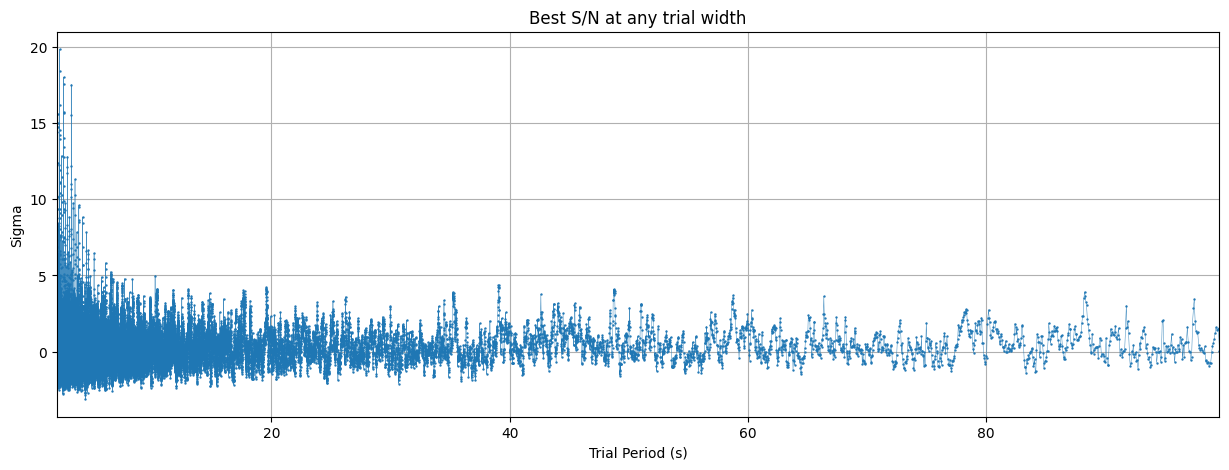

In [6]:
pgram = riptide.Periodogram(widths, periods, foldbins, snrs, {})
pgram.metadata['dm'] = dm

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(pgram.periods, pgram.snrs.max(axis=1),linewidth=0.3, marker='o', markersize=0.7)
plt.title("Best S/N at any trial width")
plt.xlim(min(pgram.periods),max(pgram.periods))
plt.xlabel("Trial Period (s)")
plt.ylabel("Sigma")
# plt.xticks(np.arange(min(pgram.periods),max(pgram.periods),2))
# plt.yticks(np.arange(-10,max(pgram.snrs.max(axis=1)),5))
plt.grid(True)
# plt.xlim(82,84)